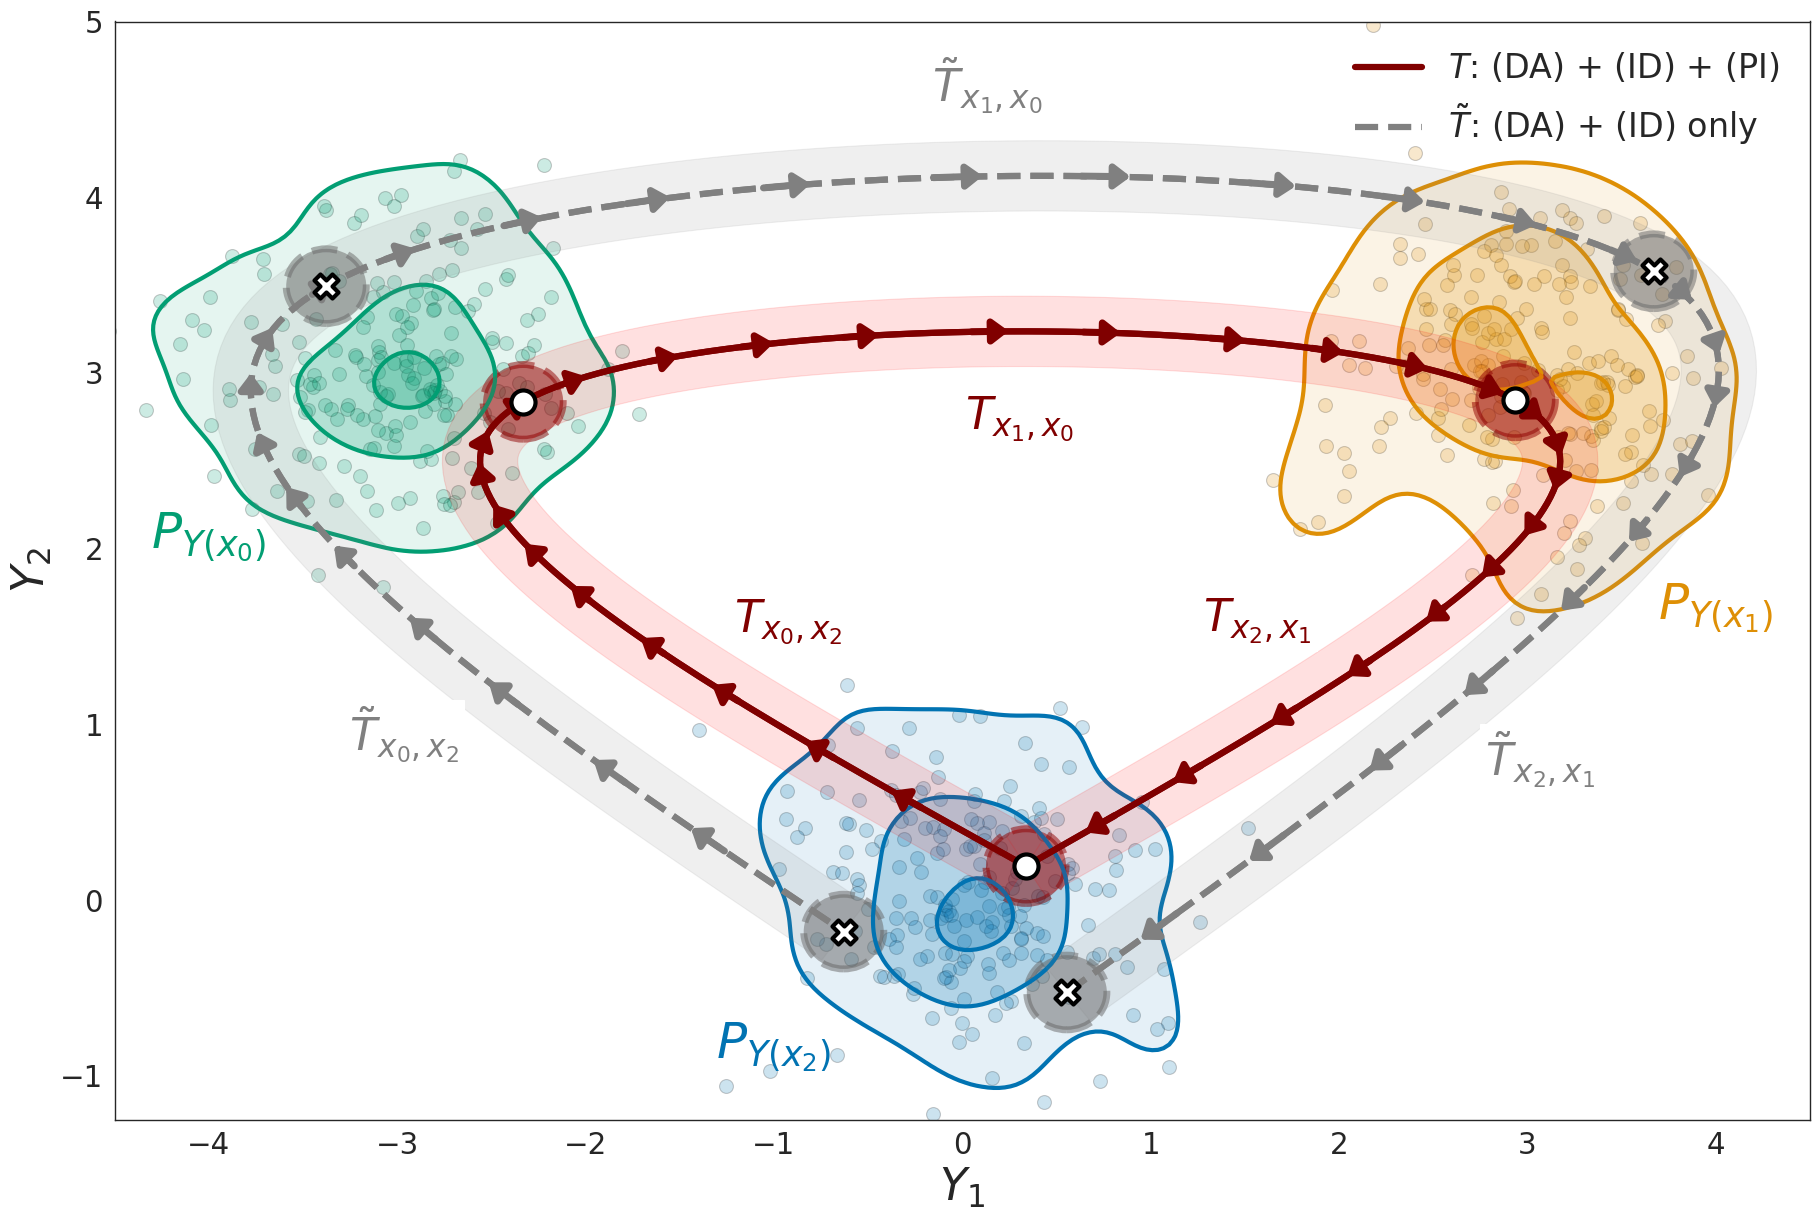

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import CubicSpline
from scipy.stats import gaussian_kde, norm, multivariate_normal
import logging
from matplotlib import patches

# Suppress font_manager messages
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# Seaborn style and colour‐blind palette
sns.set_style("white")
sns.set_context("paper", font_scale=2.4)
palette = sns.color_palette("colorblind", 3)

# -------------------------------  data  ------------------------------------- #
np.random.seed(1)
n_kde = 200
mean_P0 = np.array([0, 0])
mean_P1 = np.array([3, 3])
mean_P2 = np.array([-3, 3])
samples0 = np.random.normal(loc=mean_P0, scale=0.5, size=(n_kde, 2))
samples1 = np.random.normal(loc=mean_P1, scale=0.5, size=(n_kde, 2))
samples2 = np.random.normal(loc=mean_P2, scale=0.5, size=(n_kde, 2))

# Grid for KDE
xmin, xmax, ymin, ymax = -4.5, 4.5, -2, 6
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 300),
                     np.linspace(ymin, ymax, 300))
grid = np.vstack([xx.ravel(), yy.ravel()])

# Compute KDEs
Z0 = gaussian_kde(samples0.T)(grid).reshape(xx.shape)
Z1 = gaussian_kde(samples1.T)(grid).reshape(xx.shape)
Z2 = gaussian_kde(samples2.T)(grid).reshape(xx.shape)

# Contour‐thresholds (fractions of each peak)
fractions = [0.1, 0.5, 0.9]
L0 = [Z0.max()*f for f in fractions]
L1 = [Z1.max()*f for f in fractions]
L2 = [Z2.max()*f for f in fractions]

# ---------------------------- helper: tube polygon -------------------------- #
def tube_polygon(x, y, width):
    """Return polygon (px, py) for a tube of half-width `width` around curve (x,y)."""
    dx = np.gradient(x); dy = np.gradient(y)
    s = np.hypot(dx, dy)
    s[s == 0] = 1.0
    nx, ny = -dy / s, dx / s  # unit normals
    xu, yu = x + width * nx, y + width * ny
    xl, yl = x - width * nx, y - width * ny
    px = np.concatenate([xu, xl[::-1]])
    py = np.concatenate([yu, yl[::-1]])
    return px, py

# --------------------------------- figure ----------------------------------- #
fig, ax = plt.subplots(figsize=(18, 12))

# ----- background scatter -----
for samples, col in zip((samples0, samples1, samples2), palette):
    ax.scatter(samples[:,0], samples[:,1],
               c=[col], s=100, alpha=0.2,
               edgecolor='black')

# ----- progressive HDR shading & contours -----
alphas = [0.1, 0.3, 0.5]   # light→dark for outer→inner
for Z, levels, col in zip((Z0, Z1, Z2), (L0, L1, L2), palette):
    low, mid, high = levels
    ax.contourf(xx, yy, Z, levels=[low, mid], colors=[col], alpha=alphas[0], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[mid, high], colors=[col], alpha=alphas[1], antialiased=True)
    ax.contourf(xx, yy, Z, levels=[high, Z.max()], colors=[col], alpha=alphas[2], antialiased=True)
    ax.contour(xx, yy, Z, levels=[low, mid, high], colors=[col], linestyles='solid', linewidths=3)

# Sample trajectory points (unchanged)
scale = 0.3
P0       = np.random.normal(loc=mean_P0 + np.array([+0.5,0]), scale=scale, size=(1, 2))
P0_inc   = np.random.normal(loc=mean_P0 + np.array([0.5,-0.5]),  scale=scale, size=(1, 2))
P1_cons  = np.random.normal(loc=mean_P1 + np.array([0.0,-0.5]),     scale=scale, size=(1, 2))
P2_cons  = np.random.normal(loc=mean_P2 + np.array([0,0]),  scale=scale, size=(1, 2))
P1_inc   = np.random.normal(loc=mean_P1 + np.array([0.5,0]),     scale=scale, size=(1, 2))
P2_inc   = np.random.normal(loc=mean_P2 + np.array([-0.7,0.7]),  scale=scale, size=(1, 2))
P0_alt   = np.random.normal(loc=mean_P0 + np.array([-0.5,-0.0]), scale=scale, size=(1, 2))

# Time knots and parameter
t_knots = np.array([0, 1/3, 2/3, 1])
t       = np.linspace(0, 1, 200)

# Consistent loop: P0 -> P1_cons -> P2_cons -> P0
knots_c = np.vstack([P0[0], P1_cons[0], P2_cons[0], P0[0]])
cs_xc   = CubicSpline(t_knots, knots_c[:,0], bc_type='natural')
cs_yc   = CubicSpline(t_knots, knots_c[:,1], bc_type='natural')
xc, yc  = cs_xc(t), cs_yc(t)

# Inconsistent loop: P0_inc -> P1_inc -> P2_inc -> P0_alt
knots_i = np.vstack([P0_inc[0], P1_inc[0], P2_inc[0], P0_alt[0]])
cs_xi   = CubicSpline(t_knots, knots_i[:,0], bc_type='natural')
cs_yi   = CubicSpline(t_knots, knots_i[:,1], bc_type='natural')
xi, yi  = cs_xi(t), cs_yi(t)

# ----------------------------- shaded trajectory tubes ---------------------- #
tube_w = 0.2  # visual half-width; adjust as desired (does not change the curve)

# Tube for the consistent (black) path
px, py = tube_polygon(xc, yc, tube_w)
ax.fill(px, py, color="red", alpha=0.12, zorder=2)

# Tube for the inconsistent (grey dashed) path
px, py = tube_polygon(xi, yi, tube_w)
ax.fill(px, py, color="grey", alpha=0.12, zorder=2)

# Draw the original centerlines on top
ax.plot(xc, yc, color='maroon', lw=4.5, label=r'$T$: (DA) + (ID) + (PI)', ls="-", zorder=3)
ax.plot(xi, yi, color="grey", ls='--', lw=4.5, label=r'$\tilde T$: (DA) + (ID) only', zorder=3)

# Markers at waypoints (unchanged)
ax.scatter([P0[0,0], P1_cons[0,0], P2_cons[0,0]],
           [P0[0,1], P1_cons[0,1], P2_cons[0,1]],
           marker='o', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)
ax.scatter([P0_inc[0,0], P1_inc[0,0], P2_inc[0,0], P0_alt[0,0]],
           [P0_inc[0,1], P1_inc[0,1], P2_inc[0,1], P0_alt[0,1]],
           marker='X', s=300, edgecolor='black', facecolor='white', lw=3, zorder=100)

# Labels for each distribution
ax.text(mean_P0[0]-1.0, mean_P0[1]-0.9, r'$P_{Y(x_2)}$',
        color=palette[0], ha='center', fontsize=36)
ax.text(mean_P1[0]+1.0, mean_P1[1]-1.4, r'$P_{Y(x_1)}$',
        color=palette[1], ha='center', fontsize=36)
ax.text(mean_P2[0]-1.0, mean_P2[1]-1.0, r'$P_{Y(x_0)}$',
        color=palette[2], ha='center', fontsize=36)

# Edge labels (unchanged)
pairs_cons = [(P0, P1_cons, r'$T_{x_2,x_1}$'),
              (P1_cons, P2_cons, r'$T_{x_1,x_0}$'),
              (P2_cons, P0, r'$T_{x_0,x_2}$')]
offset = 0.1

for start, end, label in pairs_cons:
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx]); perp = perp / np.linalg.norm(perp)
    mid_x += perp[0] * offset; mid_y += perp[1] * offset
    ax.text(mid_x, mid_y, label, fontsize=32, color='maroon',
            ha='center', va='center', backgroundcolor='white')

pairs_inc = [(P0_inc, P1_inc, r'$\tilde T_{x_2,x_1}$'),
             (P1_inc, P2_inc, r'$\tilde T_{x_1,x_0}$'),
             (P2_inc, P0_alt, r'$\tilde T_{x_0,x_2}$')]
offset = -1.1
t = 0 
for start, end, label in pairs_inc:
    mid_x = (start[0,0] + end[0,0]) / 2
    mid_y = (start[0,1] + end[0,1]) / 2
    dx = end[0,0] - start[0,0]
    dy = end[0,1] - start[0,1]
    perp = np.array([-dy, dx]); perp = perp / np.linalg.norm(perp)
    if t == 1:
        off = offset
    else:
        off = -1.2
    mid_x += perp[0] * off; mid_y += perp[1] * off
    ax.text(mid_x, mid_y, label, fontsize=32, color='grey',
            ha='center', va='center', backgroundcolor='white')
    t += 1

# --------------------- shaded regions around each waypoint ------------------- #
def add_region(center, width, height, edge_color, face_color, ax, angle=0, alpha=0.5, lw=5):
    """Add an ellipse region (positive-measure neighborhood) with dashed edge."""
    e = patches.Ellipse(
        (center[0,0], center[0,1]),
        width=width, height=height, angle=angle,
        facecolor=face_color, edgecolor=edge_color,
        linewidth=lw, linestyle= "dashed",  # dashed boundary
        alpha=alpha
    )
    ax.add_patch(e)

# Consistent path regions (maroon)
W, H = 0.425, 0.425
maroon = (128/255, 0, 0)
add_region(P0,      W, H, edge_color=maroon, face_color=maroon, ax=ax)
add_region(P1_cons, W, H, edge_color=maroon, face_color=maroon, ax=ax)
add_region(P2_cons, W, H, edge_color=maroon, face_color=maroon, ax=ax)

# Inconsistent path regions (gray)
gray = (0.4, 0.4, 0.4)
add_region(P0_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P1_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P2_inc,  W, H, edge_color=gray, face_color=gray, ax=ax)
add_region(P0_alt,  W, H, edge_color=gray, face_color=gray, ax=ax)

def add_arrows_along_line(ax, x, y, n_arrows=3, color="k", lw=3, size=20, clockwise=True):
    """Add arrows along a parametric curve (x,y). If clockwise=True, flip orientation."""
    s = np.linspace(0, len(x)-1, n_arrows+2, dtype=int)[1:-1]  # skip first/last
    for idx in s:
        dx = x[idx+1] - x[idx-1]
        dy = y[idx+1] - y[idx-1]
        if clockwise:
            dx, dy = -dx, -dy  # flip direction
        ax.annotate("",
            xy=(x[idx]+dx, y[idx]+dy),
            xytext=(x[idx], y[idx]),
            arrowprops=dict(
                arrowstyle="-|>,head_width=0.3,head_length=0.4",
                color=color, lw=lw,
                shrinkA=0, shrinkB=0
            ))

# Draw the original centerlines on top
ax.plot(xc, yc, color='maroon', lw=4.5, ls="-", zorder=3)
ax.plot(xi, yi, color="grey", lw=4.5, ls="--", zorder=3)

# Add arrows showing orientation (clockwise)
add_arrows_along_line(ax, xc, yc, n_arrows=30, color="maroon", lw=5)
add_arrows_along_line(ax, xi, yi, n_arrows=30, color="grey", lw=5)

# Final styling
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin+0.75, ymax-1)
ax.set_xlabel(r"$Y_1$", fontsize=32)
ax.set_ylabel(r"$Y_2$", fontsize=32)
ax.legend(loc='upper right', frameon=False, fontsize=24)
plt.tight_layout(pad=0)
plt.savefig("CPIproperty_tubes.png", bbox_inches="tight", dpi=300)
plt.show()